# Select aviso datacube

(Utiliser l'environnement *data-env*)

L'objectif est d'extraire des cubes de données autour d'un ensemble de points d'observations à partir d'un datacube (time, lon, lat).

## Configuration

### Librairies

In [2]:
import sys
import time
from pathlib import Path
from datetime import datetime, timedelta

import intake
import numpy as np
import pandas as pd
import xarray as xr
from dask.distributed import LocalCluster, Client
from IPython.display import display

sys.path.insert(0, '../..')
from histlib.observations import (
    generate_virtual_observations,
    plot_observations,
)

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
cluster = LocalCluster()
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 4,Total memory: 16.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:56230,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 4
Started: Just now,Total memory: 16.00 GiB
Comm: tcp://127.0.0.1:46006,Total threads: 1
Dashboard: http://127.0.0.1:60405/status,Memory: 4.00 GiB
Nanny: tcp://127.0.0.1:36394,


## Observations

In [5]:
N = 1000 # Nombre de points d'observations
extent = (-180, 180, -90, 90) # Extension spatiale (lon_min, lon_max, lat_min, lat_max)
period = ('2000-01-01', '2001-01-01') # Extension temporelle (start_date, end_date)

In [6]:
# Génération des points d'observations
ds = generate_virtual_observations(N, extent, period)

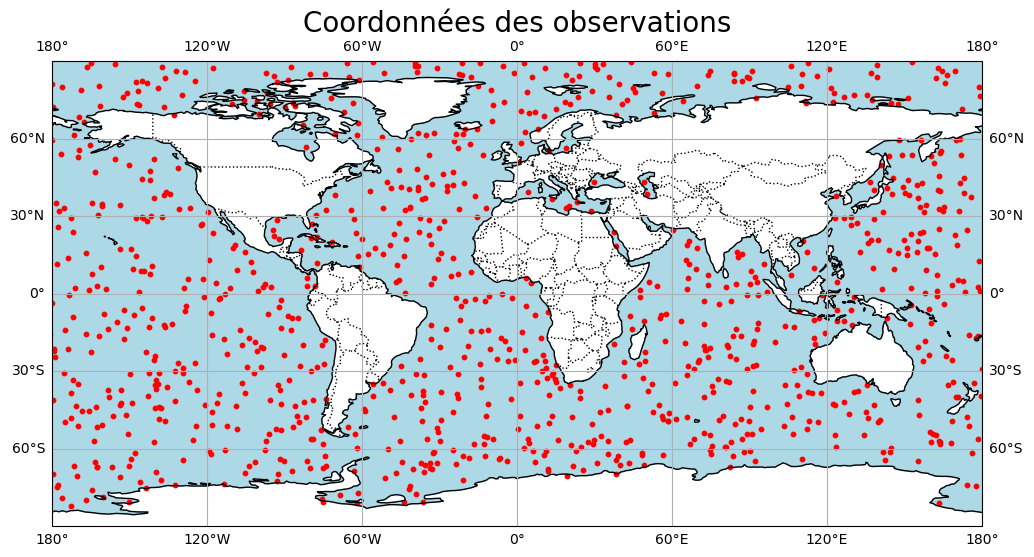

In [7]:
# Affichage sur une carte
plot_observations(ds)

## Datacube

In [8]:
dataset = 'aviso' # Nom du jeu de données (aviso / erastar)
name = 'datacube-1' # Nom du datacube

In [22]:
# Définir la taille des chunks
chunks = dict(time=5, lat=50, lon=50)

In [9]:
%%time
# Chargement du datacube
WRK = Path(f'/home1/datawork/gcaer/data/{dataset}/{name}')
cat = intake.open_catalog(WRK / f"references/aviso/reference.yaml")
datacube = cat["data"](chunks={"time": chunks['time'], "latitude": chunks['lat'], "longitude": chunks['lon']}).to_dask()

CPU times: user 6.74 s, sys: 924 ms, total: 7.67 s
Wall time: 11.8 s


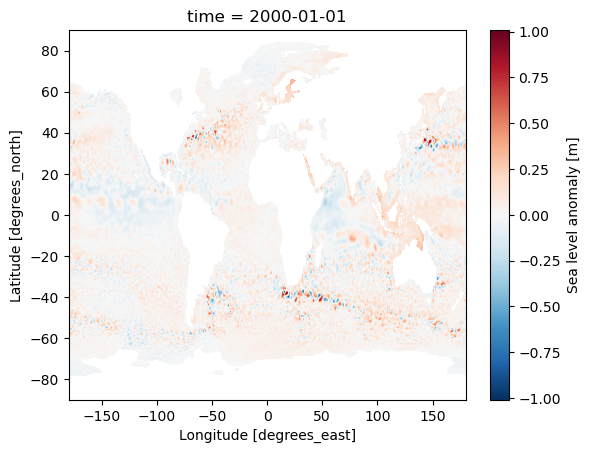

In [10]:
datacube.isel(time=0).sla.plot()

## Select cubes

Ici, on parcours les observations les unes après les autres en selectionnant le cube au sein du datacube.

In [11]:
# Définition des paramètres
dt, dlon, dlat = 2, 5, 5 # +/- dt jours, +/- dlon° de longitude, +/- dlat° de latitude
dl = 0.25 # le pas spatial (entre 2 valeurs de longitude)

### 1) Séquentielle

Ici, on parcours les observations les unes après les autres en selectionnant le cube au sein du datacube.

In [ ]:
%%time
results = []
for idx, obs in enumerate(ds.obs):
    
    #display(f"{idx}/{len(ds.obs)}", clear=True)
    
    start, end = obs.time + pd.Timedelta(days=-dt), obs.time + pd.Timedelta(days=dt)
    lon_min, lon_max = obs.lon - dlon, obs.lon + dlon
    lat_min, lat_max = obs.lat - dlat, obs.lat + dlat
    
    # Sélection d'un cube au sein du datacube
    results.append(
        datacube.sel(
            time=slice(start,end),
            longitude=slice(lon_min, lon_max),
            latitude=slice(lat_min, lat_max),
        ).compute()
    )

### 2) Vectorielle

Ici, on selectionne les cubes de chaque observations en une seul fois, *(/!\ Ce sont des cubes de même tailles)*

#### a) Same shape cubes (2D arrays)

#### b) Different shape cubes (1D flatten arrays)

In [12]:
%%time
# Génération des slices des cubes à partir des observations
i_time, i_lon, i_lat = [], [] , []
for idx, obs in enumerate(ds.obs):
    
    #display(f"{idx+1}/{len(ds.obs)}", clear=True)
    
    start, end = obs.time + pd.Timedelta(days=-dt), obs.time + pd.Timedelta(days=dt+1)
    lon_min, lon_max = obs.lon - dlon, obs.lon + dlon
    lat_min, lat_max = obs.lat - dlat, obs.lat + dlat
    
    s_time = slice(start.values, end.values, timedelta(days=1))
    s_lon = slice(lon_min, lon_max, dl)
    s_lat = slice(lat_min, lat_max, dl)
    
    i_time.append(np.r_[s_time])
    i_lon.append(np.r_[s_lon])
    i_lat.append(np.r_[s_lat])

CPU times: user 3.92 s, sys: 0 ns, total: 3.92 s
Wall time: 3.71 s


In [13]:
%%time
# Génération des listes d'indices à plat à partir des slices
f_time, f_lat, f_lon = [], [], []
pos, shapes = [], []
n=0
for it, ila, ilo in zip(i_time, i_lat, i_lon):
    
    # Créer des grilles multidimensionnelles
    gt, gla, glo = np.meshgrid(it, ila, ilo, indexing='ij')

    # Mise à plat des indices
    ft = gt.flatten()
    fla = gla.flatten()
    flo = glo.flatten()

    # Ajouter les indices à plat du cube, dans la liste des indices à plat
    f_time.extend(ft)
    f_lat.extend(fla)
    f_lon.extend(flo)

    # Enregistre la dimension du cube
    shapes.append((len(it), len(ila), len(ilo)))
    
    # Enregistre les indices correspondant au cube
    n1 = n + len(ft)
    pos.append(slice(n, n1))       
    n = n1

CPU times: user 1.38 s, sys: 240 ms, total: 1.62 s
Wall time: 1.69 s


In [16]:
%%time
# Sélection dans le datacube
result = datacube.sel(
    time=xr.DataArray(f_time,  dims="points"),
    longitude=xr.DataArray(f_lon,  dims="points"),
    latitude=xr.DataArray(f_lat,  dims="points"),
    method="nearest",
).compute()

CPU times: user 1min 17s, sys: 1.89 s, total: 1min 19s
Wall time: 1min 41s


In [17]:
len(f_time)

800000